# Lesson6 ニューラルネットに画像を生成させよう

## 目次

- Section3 テクニック・発展的内容
  - 3.1 Conditional GAN

In [1]:
!pip uninstall -y tensorflow

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1


In [2]:
!pip install tensorflow-gpu==1.13.1 tensorflow-tensorboard==0.4.0rc3 Keras==2.1.2

     |████████████████████████████████| 345.0MB 30kB/s 
     |████████████████████████████████| 1.7MB 40.2MB/s 
     |████████████████████████████████| 307kB 53.3MB/s 
     |████████████████████████████████| 3.2MB 54.4MB/s 
     |████████████████████████████████| 368kB 47.0MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp37-none-any.whl size=107222 sha256=a5efda8ea19d7fa4f88e60b285c86f620da577bed2ec3e9b09ba155e8dc5b165
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Foun

In [3]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

2.1.2
1.13.1


In [4]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test


def plot_mnist_conditional(n_ex=10,dim=(2, 5), figsize=(8,4), labels=range(10)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    label_batch = np.eye(10)[np.arange(10)]
    generated_images = generator.predict([noise, label_batch])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### 3.1 Conditional GAN

Section1では生成する画像のコントロールが出来ませんでした。つまり、数字の1が生成したくてもGeneratorにそうするように制御することが出来ませんでした。

Section3ではラベルを指定することで任意の数字を生成出来るように制御出来るConditional GANを実装して、ニューラルネットに好きな数字を生成させてみましょう。

### 3.1.1 Conditional GANとは？

基本的にはSection1で作成したネットワークと同じです。違いはGeneratorとDiscriminatorのそれぞれにラベルに対応した数字のラベルも入力するところです。

<img src='figures/gan2.png' alt='gan_2'>

### 3.1.2 Generator

Section1のGANとの違いはランダムノイズに数字のラベル情報を結合しているところです。

以下の実装のようにラベル情報もGeneratorのinputに追加されています。

つまり、要素の100のノイズと要素10のone-hotベクトルのラベル情報を入力として、サイズ28x28でチャンネル1の画像を出力にしています。

In [5]:
from tensorflow.keras.layers import Input, concatenate, Reshape, Dense, Activation, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def Generator():
    
    nch=200
    ## 1章のGANとの違い ##
    # ランダムなノイズ
    model_input = Input(shape=[100])
    # 0~9のどの数字の画像かのラベル情報
    cond = Input(shape=[10])
    # 上記2つを結合する
    cond_input = concatenate([model_input, cond], axis=-1) 
    
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(cond_input) # 110 -> 200*14*14
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x) # 200*14*14 -> 14x14x200
    x = UpSampling2D(size=(2, 2))(x) # 14x14x200 -> 28x28x200
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x200 -> 28x28x100
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x100 -> 28x28x50
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x) # 28x28x50 -> 28x28x1
    model_output = Activation('sigmoid')(x)
    model = Model([model_input, cond], model_output)
    # model.summary()
    
    return model

### 3.1.3 Discriminator

Section1のGANとの違いは画像に加えて、数字のラベル情報を結合しているところです。

以下の実装のようにラベル情報もDiscriminatorのinputに追加されています。

入力としてはサイズ28x28でチャンネル1の画像と要素10のone-hotベクトルのラベル情報を入力にして、その画像がデータセットにある本物データかどうかを2値で出力します。

注意するのは画像とラベル情報を結合するところです。ラベル情報を28x28x10にreshapeしているところがポイントです。

また、実装に関して今回LambdaというLayerを利用するので説明をします。

Kerasでネットワークを構築するときにLayerに定義された層以外を使いたいときは、Lambdaというlayerを用いてラップする必要があります。
例えば、値を2乗するLayerを追加するときは以下のようにしてLambdaでラップします。

```
Lambda(lambda x: x ** 2)
```

In [6]:
from tensorflow.keras.layers import Input, concatenate, Lambda, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    
    ## 1章のGANとの違い ##
    model_input = Input(shape=shape)
    cond = Input(shape=[10])
    
    # ここでラベル情報をreshape
    cond_reshape = Reshape( [1, 1, 10] )(cond) # 1x1x10
    cond_reshape = Lambda(lambda x: K.ones([28, 28, 10])*x)(cond_reshape) # 1x1x10 -> 28x28x10
    cond_input = concatenate([model_input, cond_reshape], axis=-1) # 28x28x11
    
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(cond_input) # 28x28x11 -> 14x14x256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x) # 14x14x256 -> 7x7x512
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x) # 7x7x512 -> 7*7*512
    x = Dense(1024)(x) # 7*7*512 -> 1024
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x) # 1024 -> 512
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x) # 512 -> 256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x) # 256 -> 2
    model = Model([model_input, cond], model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

Instructions for updating:
Colocations handled automatically by placer.


### 3.1.4 GANの学習

学習自体はSection1のGANとほとんど同じです。

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    cond = Input(shape=[10])
    x = generator([gan_input, cond])
    gan_output = discriminator([x, cond])
    model = Model([gan_input, cond], gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

In [8]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [9]:
from tqdm import tqdm

def train(step=3000, BATCH_SIZE=128):

    for e in tqdm(range(step)):  
        
        image_indexes = np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)
        image_batch = X_train[image_indexes,:,:,:]  
        label_batch = y_train[image_indexes]  
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict([noise_gen, label_batch])
        
        make_trainable(discriminator,True)
        
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        label_batch = np.concatenate((label_batch, label_batch))
        
        
        discriminator.train_on_batch([X, label_batch], y)
        
        make_trainable(discriminator,False)
    
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        label_batch2 = np.random.randint(0, 10, size=BATCH_SIZE)
        label_batch2 = np.eye(10)[label_batch2]
             
        GAN.train_on_batch([noise_tr, label_batch2], y2 )

### 3.1.5 MNISTによる学習

In [10]:
# network 
X_train, _, y_train, _ = load_mnist()
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


### 3.1.6 手書き文字の生成

それではニューラルネットに画像を生成させてみましょう。順に0~9が並ぶことが確認出来ると思います。

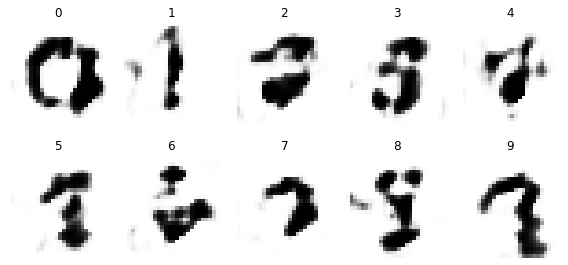

In [12]:
plot_mnist_conditional()

In [13]:
train(2000)

100%|██████████| 2000/2000 [08:25<00:00,  3.96it/s]


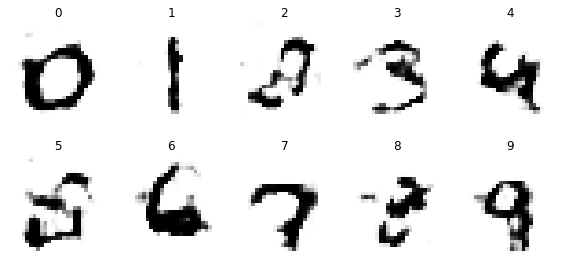

In [14]:
plot_mnist_conditional()

## Checkクイズ

- 問題1
    - 今回実装したConditional GANに関して、次の選択肢から不適切なものを一つ選びなさい
- 選択肢
    1. Conditional GANは生成する画像の数字を制御出来る。
    2. Generatorにラベルyを付与する。
    3. Discriminatorにラベルyを付与する。
    4. 潜在変数zを変えると生成する画像の数字も変わる。

- 問題2
    - Conditional GANとして最も適切なものを一つ選びなさい
-  選択肢
    1. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x|y)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z|y)))]$
    2. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z)))]$
    3. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(x|y)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z)))]$
    4. $\underset{G}{\min}\underset{D}{\max}V(D, G) = E_{x{\sim}p_{data}(x)}[\log D(y)] +E_{z{\sim}p_{data}(z)}[\log(1-D(G(z|y)))]$

In [ ]:
④①